# Modeling and Simulation in Python

Insulin minimal model

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Data

We have data from Pacini and Bergman (1986), "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122..

In [2]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

### The insulin minimal model

In addition to the glucose minimal mode, Pacini and Bergman present an insulin minimal model, in which the concentration of insulin, $I$, is governed by this differential equation:

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

**Exercise:**  Write a version of `make_system` that takes the parameters of this model, `I0`, `k`, `gamma`, and `G_T` as parameters, along with a `DataFrame` containing the measurements, and returns a `System` object suitable for use with `run_simulation` or `run_odeint`.

Use it to make a `System` object with the following parameters:

In [3]:
params = Params(I0 = 360,
                k = 0.25,
                gamma = 0.004,
                G_T = 80)

,values
I0,360.000
k,0.250
gamma,0.004
G_T,80.000


In [4]:
# Solution

def make_system(params, data):
    # params might be a Params object or an array,
    # so we have to unpack it like this
    I0, k, gamma, G_T = params
    
    init = State(I=I0)
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)
    G=interpolate(data.glucose)
    
    system = System(I0=I0, k=k, gamma=gamma, G_T=G_T, G=G,
                    init=init, t_0=t_0, t_end=t_end, dt=1)

    return system

In [5]:
# Solution

system = make_system(params, data)

,values
I0,360
k,0.25
gamma,0.004
G_T,80
G,<function interpolate.<locals>.wrapper at 0x7f...
init,I 360.0 dtype: float64
t_0,0
t_end,182
dt,1


**Exercise:** Write a slope function that takes state, t, system as parameters and returns the derivative of `I` with respect to time.  Test your function with the initial condition $I(0)=360$.

In [6]:
# Solution

def slope_func(state, t, system):
    [I] = state
    k, gamma = system.k, system.gamma
    G, G_T = system.G, system.G_T
        
    dIdt = -k * I + gamma * (G(t) - G_T) * t
    
    return [dIdt]

In [7]:
# Solution

slope_func(system.init, system.t_0, system)

[-90.0]

**Exercise:** Run `run_ode_solver` with your `System` object and slope function, and plot the results, along with the measured insulin levels.

In [8]:
# Solution

results, details = run_ode_solver(system, slope_func)
details

,values
success,True
message,The solver successfully reached the end of the...


In [9]:
# Solution

results.tail()

,I
178,22.356671
179,23.180483
180,24.013211
181,24.854654
182,25.704657


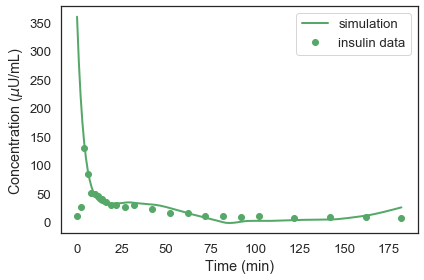

In [10]:
# Solution

plot(results.I, 'g-', label='simulation')
plot(data.insulin, 'go', label='insulin data')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

**Exercise:**  Write an error function that takes a sequence of parameters as an argument, along with the `DataFrame` containing the measurements.  It should make a `System` object with the given parameters, run it, and compute the difference between the results of the simulation and the measured values.  Test your error function by calling it with the parameters from the previous exercise.

Hint: As we did in a previous exercise, you might want to drop the errors for times prior to `t=8`.

In [11]:
# Solution

def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    actual: array of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)

    # solve the ODE
    results, details = run_ode_solver(system, slope_func)

    # compute the difference between the model
    # results and actual data
    errors = (results.I - data.insulin).dropna()
    return TimeSeries(errors.loc[8:])

In [12]:
# Solution

error_func(params, data)

I0       360.000
k          0.250
gamma      0.004
G_T       80.000
dtype: float64


,values
8,11.892725
10,-2.299827
12,-7.258477
14,-7.522652
16,-3.263455
19,2.001941
22,2.652451
27,7.047398
32,3.742283
42,8.929934


**Exercise:** Use `leastsq` to find the parameters that best fit the data.  Make a `System` object with those parameters, run it, and plot the results along with the measurements.

In [13]:
# Solution

best_params, details = leastsq(error_func, params, data)
print(details.mesg)

[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.60000005e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60000000e+02 2.50000004e-01 4.00000000e-03 8.00000000e+01]
[3.60000000e+02 2.50000000e-01 4.00000006e-03 8.00000000e+01]
[3.60000000e+02 2.50000000e-01 4.00000000e-03 8.00000012e+01]
[-5.30683629e+02 -6.79500345e-02 -2.29098225e-03  7.86040674e+01]
[2.86020929e+02 2.22835658e-01 2.97772381e-03 7.96421423e+01]
[2.86020933e+02 2.22835658e-01 2.97772381e-03 7.96421423e+01]
[2.86020929e+02 2.22835661e-01 2.97772381e-03 7.96421423e+01]
[2.86020929e+02 2.22835658e-01 2.97772385e-03 7.96421423e+01]
[2.86020929e+02 2.22835658e-01 2.97772381e-03 7.96421435e+01]
[1.40631803e+02 1.53621683e-01 1.89393929e-03 7.90793326e+01]
[1.40631805e+02 1.53621683e-01 1.89393929e-03 7.90793326e+01]
[1.40631803e+02 1.53621685e-01 1.89393929e-03 7.90793326e+01]
[1.40631803e+02 1.53621683e-01 1.89393932e-03 7.90793326e+01]
[1.40631803e+02 1.53621683

In [14]:
# Solution

system = make_system(best_params, data)

,values
I0,62.762
k,0.0327301
gamma,8.18489e-05
G_T,59.2615
G,<function interpolate.<locals>.wrapper at 0x7f...
init,I 62.762038 dtype: float64
t_0,0
t_end,182
dt,1


In [15]:
# Solution

results, details = run_ode_solver(system, slope_func, t_eval=data.index)
details

,values
success,True
message,The solver successfully reached the end of the...


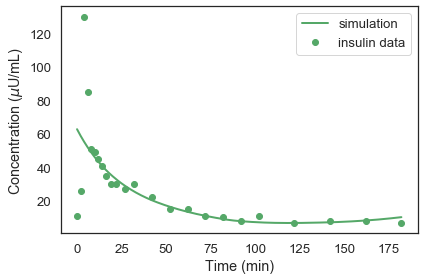

In [16]:
# Solution

plot(results.I, 'g-', label='simulation')
plot(data.insulin, 'go', label='insulin data')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

**Exercise:** Using the best parameters, estimate the sensitivity to glucose of the first and second phase pancreatic responsivity:

$ \phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)} $

$ \phi_2 = \gamma \times 10^4 $

For $G_0$, use the best estimate from the glucose model, 290.  For $G_b$ and $I_b$, use the inital measurements from the data.


In [17]:
# Solution

I0, k, gamma, G_T = best_params

In [18]:
# Solution

I_max = data.insulin.max()
Ib = data.insulin[0]
I_max, Ib

(130, 11)

In [19]:
# Solution

# The value of G0 is the best estimate from the glucose model
G0 = 289
Gb = data.glucose[0]
G0, Gb

(289, 92)

In [20]:
# Solution

phi_1 = (I_max - Ib) / k / (G0 - Gb)
phi_1

18.455830724497748

In [21]:
# Solution

phi_2 = gamma * 1e4
phi_2

0.8184889071339871